In [5]:
import os
os.chdir(r"D:\OneDrive - Universität Wien\Adameyko Lab\FS3_MP\fluorescence_images\all_fates_pax6_isi12_sox10")

(3, 4, 1024, 1024)


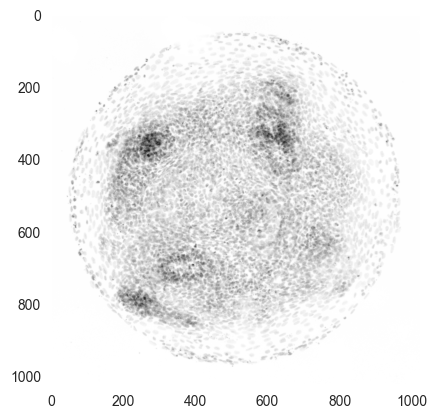

In [7]:
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
from micropattern_analysis import *

img = iio.imread(r"MP_ISTA_STAN_BMP4_800um_DAPI_pax6_555_sox10_647_isi12_488_2024_01_05__17_57_15.lsm")
#img = np.sum(img, axis=0)
print(img.shape)
dapi_img = maximise_img_channels(img)[3]
plt.imshow(dapi_img, cmap="gray_r")
plt.grid(False)
plt.show()

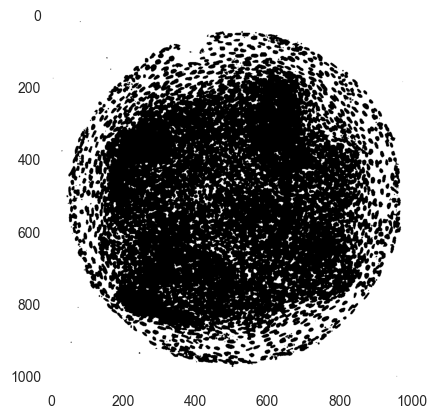

In [8]:
from skimage.filters import threshold_triangle

dapi_img_mask = dapi_img > threshold_triangle(dapi_img)
plt.imshow(dapi_img_mask, cmap="gray_r")
plt.grid(False)
plt.show()

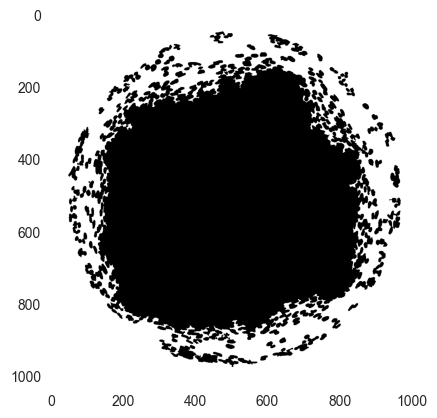

In [9]:
import skimage.morphology as morph

seed = np.copy(dapi_img_mask)
seed[1:-1, 1:-1] = dapi_img_mask.max()
dapi_img_mask = morph.remove_small_objects(dapi_img_mask, 200)
dapi_img_mask = morph.reconstruction(seed, dapi_img_mask, method="erosion")
plt.imshow(dapi_img_mask, cmap="gray_r")
plt.grid(False)
plt.show()

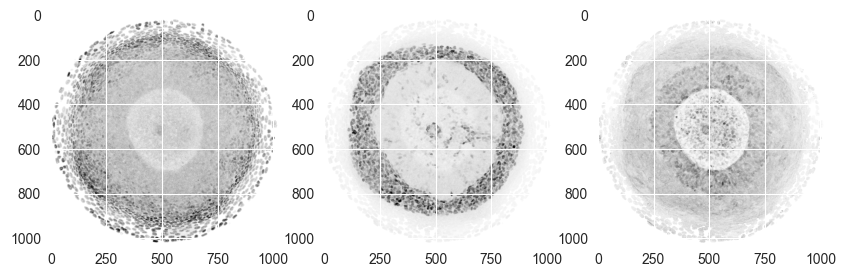

In [79]:
img_chnls = []

(fig, ax) = plt.subplots(1, 3, figsize=(10, 4))
for i in range(3):
    img_chnls.append(dapi_img_mask * img[i])
    ax[i].imshow(img_chnls[i], cmap="gray_r")
img_chnls = np.array(img_chnls)

plt.show()

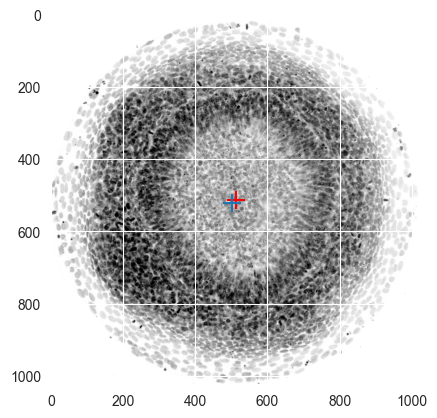

In [80]:
from skimage.measure import regionprops

properties = regionprops(dapi_img_mask.astype(int), dapi_img)
center_of_mass = np.array(properties[0].centroid).astype(int)

fig, ax = plt.subplots()
ax.imshow(dapi_img, cmap="gray_r")
ax.scatter(512, 512, s=160, c='red', marker='+')
ax.scatter(center_of_mass[1], center_of_mass[0], s=160, c='C0', marker='+')
plt.show()

In [81]:
import pandas as pd

cords = np.mgrid[0:dapi_img.shape[0], 0:dapi_img.shape[1]]     # All points in a 3D grid within the given ranges
cords = np.rollaxis(cords, 0, 3)         # Make the 0th axis into the last axis
cords = cords.reshape((dapi_img.shape[0] * dapi_img.shape[1], 2))   # Now you can safely reshape while preserving order
dist = np.linalg.norm(cords - center_of_mass, axis=1).astype(int)

df = pd.DataFrame(np.column_stack((cords, dist, np.transpose(img_chnls.reshape((3, 1024*1024))))))

In [82]:
distance_intensities = df[df.iloc[:, 4] > 0].groupby(2, sort=True).mean()
distance_intensities.reset_index(inplace=True)
distance_intensities

,2,0,1,3,4,5
0,0.0,521.000000,503.000000,1130.000000,1094.000000,578.000000
1,1.0,521.000000,503.000000,867.750000,1084.250000,714.750000
2,2.0,521.000000,503.000000,998.312500,1112.125000,739.437500
3,3.0,521.000000,503.000000,957.400000,1098.200000,749.750000
4,4.0,521.000000,503.000000,910.500000,1088.125000,753.000000
...,...,...,...,...,...,...
513,513.0,420.500000,775.346154,718.307692,170.346154,144.192308
514,514.0,339.000000,723.333333,785.722222,192.666667,147.666667
515,515.0,188.416667,703.500000,607.916667,206.333333,191.333333
516,516.0,37.400000,684.000000,532.400000,167.200000,291.600000


In [83]:
from scipy.ndimage import gaussian_filter

img_props = iio.improps("img/pax6_1.tif")
res_x, res_y = 1/np.array(img_props.spacing)

distance_intensities[6] = distance_intensities[2] * res_x
for i in range(3,6):
    sigma = np.nanmean(df[df.iloc[:, 4] > 0].groupby(2, sort=True).std()[i])
    distance_intensities[i+4] = gaussian_filter(distance_intensities[i], 4)

In [95]:
img[0][0].shape[0]/2

512.0

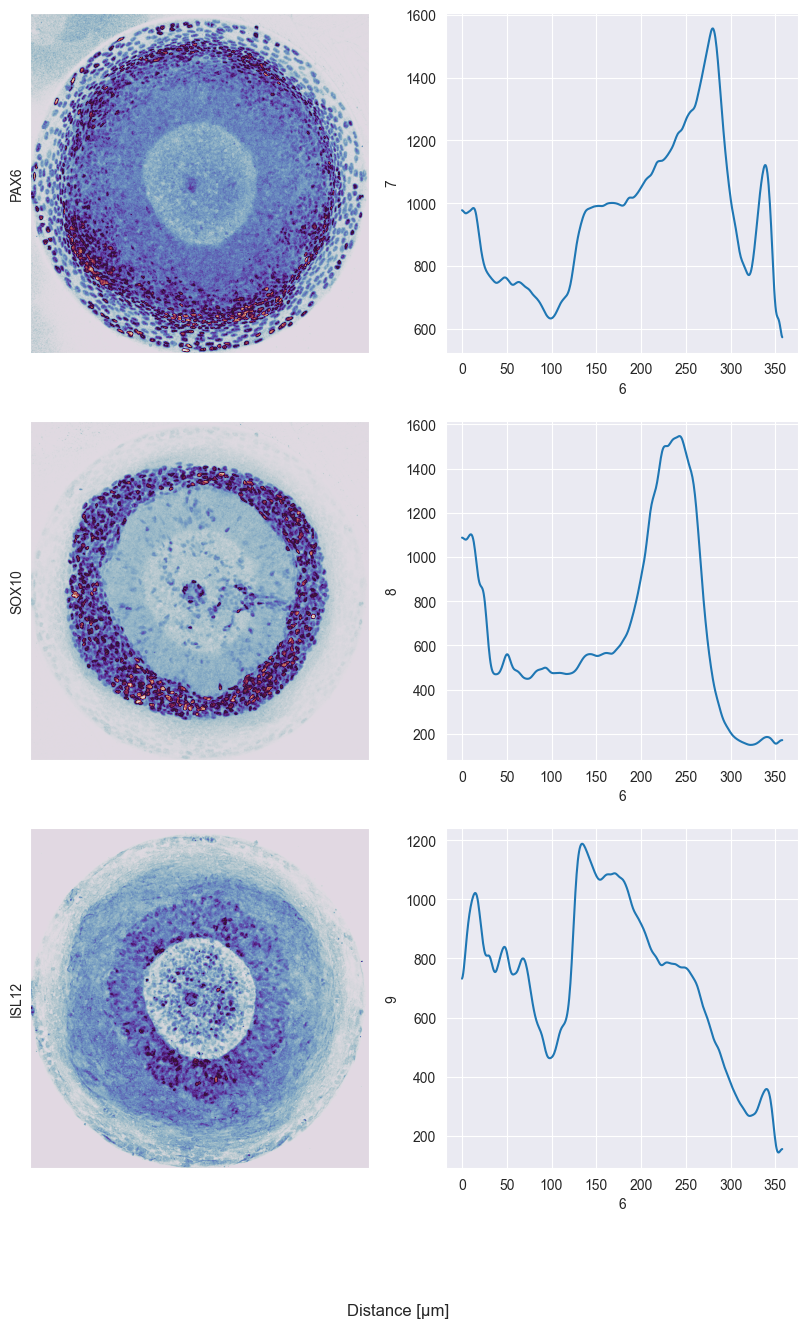

In [96]:
import seaborn as sns

y_labels = ["PAX6", "SOX10", "ISL12"]

(fig, ax) = plt.subplots(3, 2, figsize=(10, 15))
for i in range(3):
    sns.lineplot(distance_intensities, x=6, y=7+i, ax=ax[i][1])
    ax[i][0].imshow(img[i], cmap="twilight")
    ax[i][0].set_ylabel(y_labels[i])
    ax[i][0].set_xticks(np.arange(-img[i][0].shape[0]/2, -img[i][0].shape[0]/2, 1))
    ax[i][0].set_yticks(np.arange(-img[i][1].shape[0]/2, -img[i][1].shape[0]/2, 1))
fig.supxlabel("Distance [µm]")
plt.show()

# NEW BLOCK

In [4]:
import os

dir = r"D:\OneDrive - Universität Wien\Adameyko Lab\FS3_MP\fluorescence_images"
os.chdir(dir)
dirs = os.listdir(".")
print(dirs)

['ab testing', 'all_fates_neg_ctr', 'all_fates_pax6_isi12_sox10', 'all_fates_six1_isi12_sox10', 'Lost and Found Florian']


In [5]:
dirs = dirs[2:4]
print(dirs)

['all_fates_pax6_isi12_sox10', 'all_fates_six1_isi12_sox10']


In [7]:
from micropattern_analysis import *
files = [file for file in gather_files(dirs) if "stencil" not in file]

all_fates_pax6_isi12_sox10
all_fates_six1_isi12_sox10


30

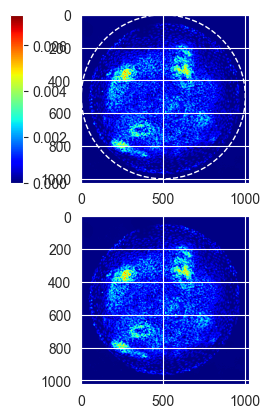

In [83]:
img = iio.imread(files[0])
dapi = maximise_img_channels(img)[3]
dapi_norm = dapi / np.linalg.norm(dapi)

circle1 = plt.Circle((500, 500), 500, linestyle='--', fill=False)

fig, ax = plt.subplots(2, 1)
ax[0].imshow(dapi, cmap="jet")
ax[0].tick_params(
        axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False
)
ax[0].add_patch(circle1)
im = ax[1].imshow(dapi_norm, cmap="jet")
pos = fig.add_axes([0.27, 0.53, 0.02, 0.35])
fig.colorbar(im, cax=pos)
plt.show()

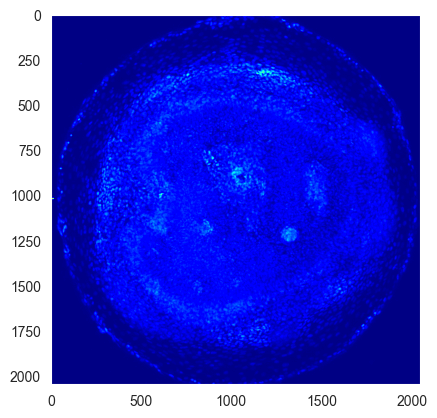

In [11]:
import imageio.v3 as iio
import matplotlib.pyplot as plt
import numpy as np



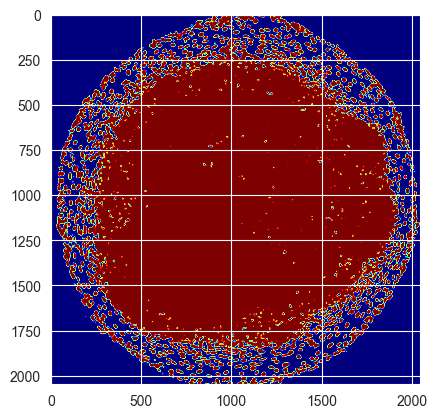

In [12]:
from skimage.filters import threshold_triangle

dapi_img = maximise_img_channels(img)[3]

dapi_image = dapi_img > threshold_triangle(dapi_img)

plt.imshow(dapi_image, cmap="jet")
plt.show()